In [1]:
import os
import numpy as np
import pickle
import corner as DFM

import env
import util as UT
import nongauss as NG

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
pks, k = NG.dataX('patchy.z1', ell=0, krange=[0., 0.15], sys='fc', k_arr=True)
n_mock = pks.shape[0]

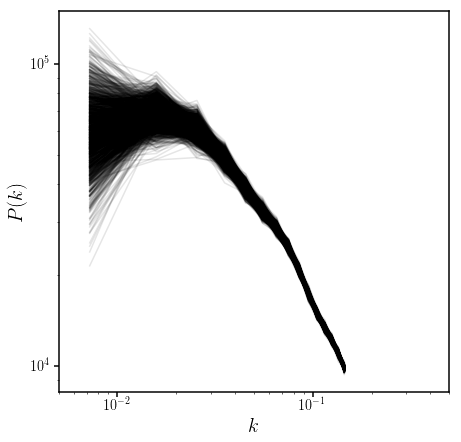

In [4]:
fig = plt.figure(figsize=(7,7))
sub = fig.add_subplot(111)
for i in range(pks.shape[0]): 
    sub.plot(k, pks[i,:], c='k', alpha=0.1)
sub.set_xscale('log')
sub.set_xlim([0.005, 0.5])
sub.set_xlabel('$k$', fontsize=20)
sub.set_yscale('log')
sub.set_ylabel('$P(k)$', fontsize=20)

In [5]:
pk_avg = (np.sum(pks, axis=0)/float(n_mock))
pks_white, W = NG.whiten(pks - pk_avg)

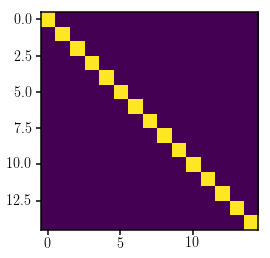

In [6]:
C_pk = np.cov(pks_white.T)
plt.imshow(C_pk)

In [7]:
mvn = np.random.multivariate_normal
gauss = mvn(np.zeros(len(pk_avg)), C_pk, size=2500) # reference Gaussian distribution

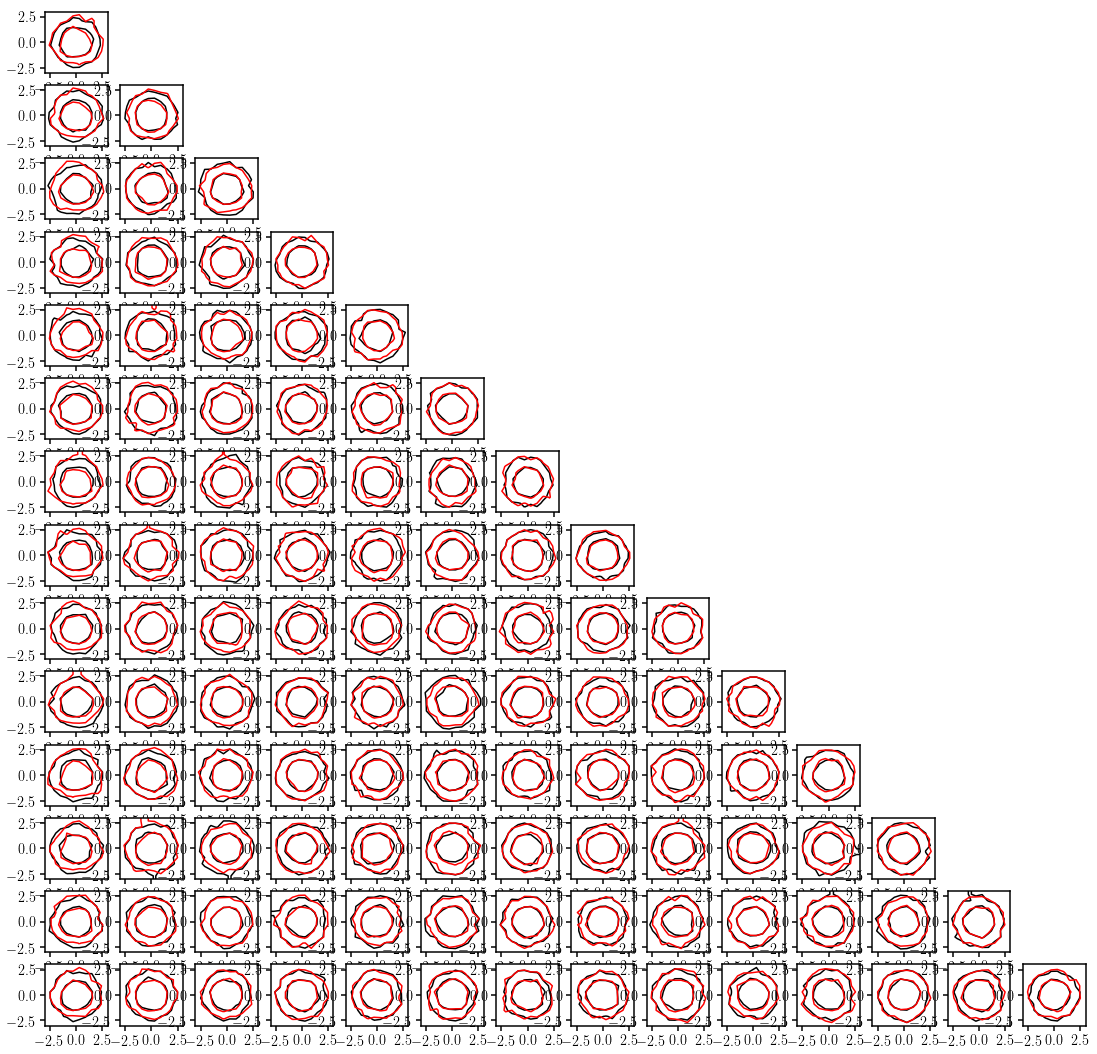

In [8]:
fig = plt.figure(figsize=(20,20))
for i in range(len(pk_avg)): 
    for j in range(len(pk_avg)): 
        if i > j: 
            sub = fig.add_subplot(len(pk_avg), len(pk_avg), len(pk_avg)*i+j+1)
            DFM.hist2d(gauss[:,i], gauss[:,j], color='k',
                       levels=[0.68, 0.95], range=[[-3.,3.], [-3.,3]], bins=10,
                       plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub) 
            #sub.scatter(gauss[:,i], gauss[:,j])
            DFM.hist2d(pks_white[:,i], pks_white[:,j], color='r',
                       levels=[0.68, 0.95], range=[[-3.,3.], [-3.,3]], bins=10,
                       plot_datapoints=False, fill_contours=False, plot_density=False, ax=sub) 
            #sub.scatter(gmfs_white[:,i], gmfs_white[:,j])
            sub.set_xlim([-3., 3.])
            sub.set_ylim([-3., 3.])

In [23]:
div_knns, div_knns_ref = [], [] 
Ks = [4,5,6,7,8,9]
n = 200 
for i in range(n): 
    div_knn_i = NG.kNNdiv_gauss(pks_white, C_pk, Knn=Ks, div_func='renyi:.5', Nref=5000)
    if i == 0: 
        div_knn = div_knn_i
    else: 
        div_knn += div_knn_i #kNN.fit_transform(feat)
    div_knns.append(div_knn_i)
    
    gauss2 = mvn(np.zeros(len(pk_avg)), C_pk, size=n_mock)
    div_knn_ref_i = NG.kNNdiv_gauss(gauss2, C_pk, Knn=Ks, div_func='renyi:.5', Nref=5000)
    div_knns_ref.append(div_knn_ref_i)
div_knn /= float(n)

In [24]:
print div_knn

[-0.20686351 -0.20629741 -0.21052411 -0.21060803 -0.21424908 -0.21953865]


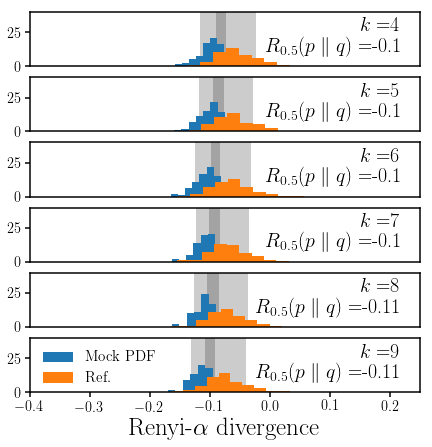

In [41]:
fig = plt.figure(figsize=(7,7))
for i in range(len(Ks)):
    sub = fig.add_subplot(len(Ks),1,i+1)
    _ = sub.hist(np.array(div_knns)[:,i], normed=True, label='Mock PDF')    
    _ = sub.hist(np.array(div_knns_ref)[:,i], normed=True, label='Ref.')#, range=[-1, 2.], bins=60)
    sig_knn_ref_i = np.std(np.array(div_knns_ref)[:,i])
    sub.fill_between([np.average(np.array(div_knns_ref)[:,i])-sig_knn_ref_i, np.average(np.array(div_knns_ref)[:,i])+sig_knn_ref_i],
                     [0., 0.], [50., 50.], color='k', alpha=0.2, linewidth=0)
    #sub.vlines(np.average(np.array(div_knns_ref)[:,i]), 0, 20, linestyle='--', linewidth=1, color='k')
    sig_knn_i = np.std(np.array(div_knns)[:,i])
    sub.fill_between([div_knn[i]-sig_knn_i, div_knn[i]+sig_knn_i], 
                     [0., 0.], [50., 50.], color='k', alpha=0.2, linewidth=0)
    #sub.vlines(div_knn[i], 0, 20, linestyle='-', linewidth=1, color='k')
    sub.set_xlim([-0.4, 0.25])
    if i != len(Ks)-1:
        sub.set_xticks([])
    sub.set_ylim([0, 40])
    sub.text(0.95, 0.9, '$k=$'+str(Ks[i])+'\n $R_{0.5}(p \parallel q) = $'+str(round(div_knn[i],2)), 
             ha='right', va='top', transform=sub.transAxes, fontsize=20)
sub.set_xlabel(r'Renyi-$\alpha$ divergence', fontsize=25)
sub.legend(loc='upper left', prop={'size':15})

In [37]:
div_knns, div_knns_ref = [], [] 
Ks = [4,5,6,7,8,9]
n = 200 
for i in range(n): 
    div_knn_i = NG.kNNdiv_gauss(pks_white, C_pk, Knn=Ks, div_func='kl', Nref=3000)
    if i == 0: 
        div_knn = div_knn_i
    else: 
        div_knn += div_knn_i #kNN.fit_transform(feat)
    div_knns.append(div_knn_i)
    
    gauss2 = mvn(np.zeros(len(pk_avg)), C_pk, size=n_mock)
    div_knn_ref_i = NG.kNNdiv_gauss(gauss2, C_pk, Knn=Ks, div_func='kl', Nref=3000)
    div_knns_ref.append(div_knn_ref_i)
div_knn /= float(n)

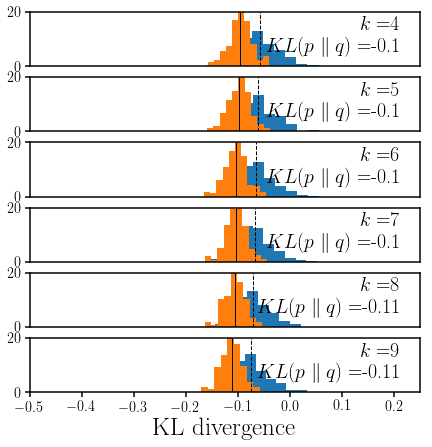

In [38]:
fig = plt.figure(figsize=(7,7))
for i in range(len(Ks)):
    sub = fig.add_subplot(len(Ks),1,i+1)
    _ = sub.hist(np.array(div_knns_ref)[:,i], normed=True)#, range=[-1, 2.], bins=60)
    _ = sub.hist(np.array(div_knns)[:,i], normed=True)
    sub.vlines(np.average(np.array(div_knns_ref)[:,i]), 0, 20, linestyle='--', linewidth=1, color='k')
    sub.vlines(div_knn[i], 0, 20, linestyle='-', linewidth=1, color='k')
    sub.set_xlim([-0.5, 0.25])
    if i != len(Ks)-1:
        sub.set_xticks([])
    sub.set_ylim([0, 20])
    sub.text(0.95, 0.9, '$k=$'+str(Ks[i])+'\n $KL(p \parallel q) = $'+str(round(div_knn[i],2)), 
             ha='right', va='top', transform=sub.transAxes, fontsize=20)
sub.set_xlabel(r'KL divergence', fontsize=25)